## B1957+20 Demonstration
This notebook will run through the sampling for B1957+20, reproducing the results presented in the paper

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from shoogle.gibbs_sampler import Gibbs
from shoogle.plot_gibbs_results import GibbsResults

import jax
import jax.numpy as jnp
import corner

### Timing model

The timing model in `B1957+20_shoogle_input.par` is the GPTA DR1 model, from [zenodo](https://zenodo.org/records/6374291), with WAVEX and ORBWAVEs components (basis vectors for spin/orbital noise models) initialised to zero, and all timing parameters (EPS1, EPS2, PMRA, PMDEC, PX) free to vary in the fit. Astrometry is constrained with Gaussian priors on RAJ, DECJ, PMRA, PMDEC, and PX from Gaia, defined in `B1957+20_shoogle_input.priors` (in the same style as a normal PINT .par file).  


### Noise hyperparameters
Noise model hyperparameters are also specified in the priors file:

```
OPV_REDAMP       -7.5                      1
OPV_REDFC        -1.0                      1
OPV_REDGAM       4.0                       1
TN_REDAMP        -13                       2
TN_REDFC         -1.95                     0
TN_REDGAM        4.333333                  0
```

The "OPV" lines describe a smoothly-broken power-law for the orbital phase variations, with all three parameters free to vary (REDAMP = log10(amplitude), REDFC = log10(corner frequency / yr^-1), REDGAM = spectral index).

The "TN" lines describe a power-law model for red timing noise (REDFC = -1.95 is well below 1/Tobs, so although we're using a broken power-law model, the break is well below the frequencies that the data is sensitive to). 
Here only the amplitude is free to vary, with the spectral index fixed at the 4.3333 value expected for a stochastic gravitational wave background produced by SMBHs. The "2" in the free/fixed column causes shoogle to place a uniform prior on the amplitude, rather than the log-amplitude. This is because this noise component is not well constrained by the data, so the default log-uniform prior would result in a 95% confidence upper limit that depends entirely on the lower limit of the prior on the log-amplitude.

In [3]:
# Initialising the sampler object
psr = Gibbs(ft1file="B1957+20_GPTA_DR1_wcut.fits",
            ft2file="FT2.fits",
            weightfield="4FGL J1959.5+2048",
            wmin=0.05,
            parfile="B1957+20_shoogle_input.par",
            templatefile="B1957+20_shoogle_input.prof",
            priorfile="B1957+20_shoogle_input.priors")

Loading FT1 file
Constructing design matrix


### Run the sampling!

This could take some time, 1-2 hours, depending on your hardware. 

It will go *much* faster if you have a GPU-based JAX installation!

In [4]:
psr.sample(n_acor_target=1000,update=100,outputfile='B1957+20_shoogle_output',resume=False,plots=False,num_NUTS_steps=1,seed=0)

Optimising timing model with fixed template
logL : 422.57 -> 563.33
Setting up template sampler
Running window adaptation


<div><progress max="2000" value="2000"></progress> 100.00% [2000/2000 00:00&lt;?]</div>


Re-optimising timing model with burnt-in template
logL : 708.14 -> 723.96
Setting up hyper-parameter sampler
Running window adaptation


<div><progress max="2000" value="2000"></progress> 100.00% [2000/2000 00:00&lt;?]</div>


JIT-compiling the Gibbs sampler


Gibbs sampling:   0%|          | 0/100000 [00:00<?, ?it/s]

### Create a GibbsResults object to interpret/plot the sampling results

In [5]:
res = GibbsResults(psr)
res.load_results(['B1957+20_shoogle_output.npz'],decimated=True)
res.write_new_parfile('B1957+20_shoogle_output_orbwaves.par')
res.write_new_template('B1957+20_shoogle_output_prof.txt')


### Make a corner plot of the OPV/TN hyperparameters (Fig. 5 from the paper)

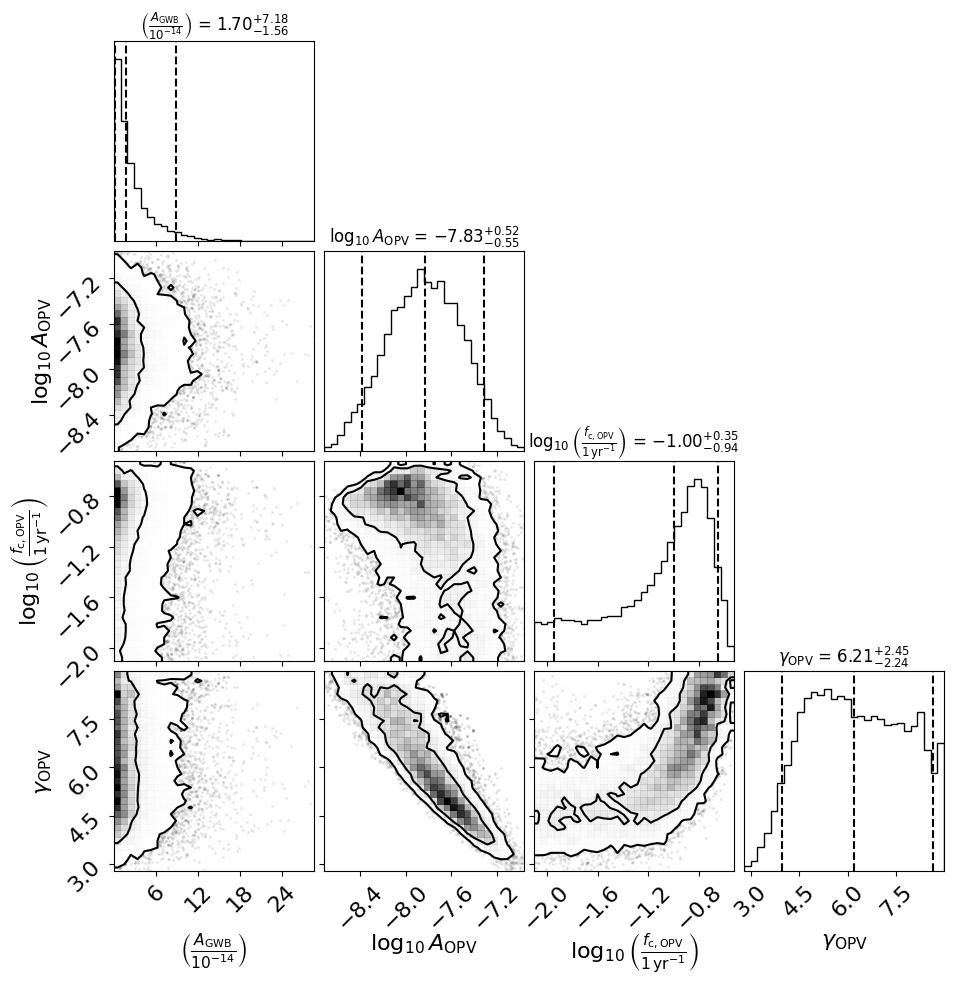

In [6]:
h = np.copy(res.hyp_chain)
h[:,0] = 10 ** h[:,0] / 1e-14
import corner
plt.rc('font',size=16)
corner.corner(h,
              bins=30,
              range=[0.999,0.999,0.999,0.999],
              title_fmt='.2f',
              #levels=1.0 - np.exp(-0.5 * np.arange(1,3) ** 2),
              levels=[0.683, 0.954],
              labels=['$\\left(\\frac{A_{\\rm GWB}}{10^{-14}}\\right)$','$\\log_{10} A_{\\rm OPV}$','$\\log_{10} \\left(\\frac{f_{\\rm c, OPV}}{1\\,{\\rm yr}^{-1}}\\right)$','$\\gamma_{\\rm OPV}$'], 
              show_titles=True,
              title_kwargs = {'size':12},
              quantiles = [0.05,0.5,0.95])
plt.savefig('B1957_corner.pdf',bbox_inches='tight')
plt.show()

### Make a corner plot of the timing model parameters

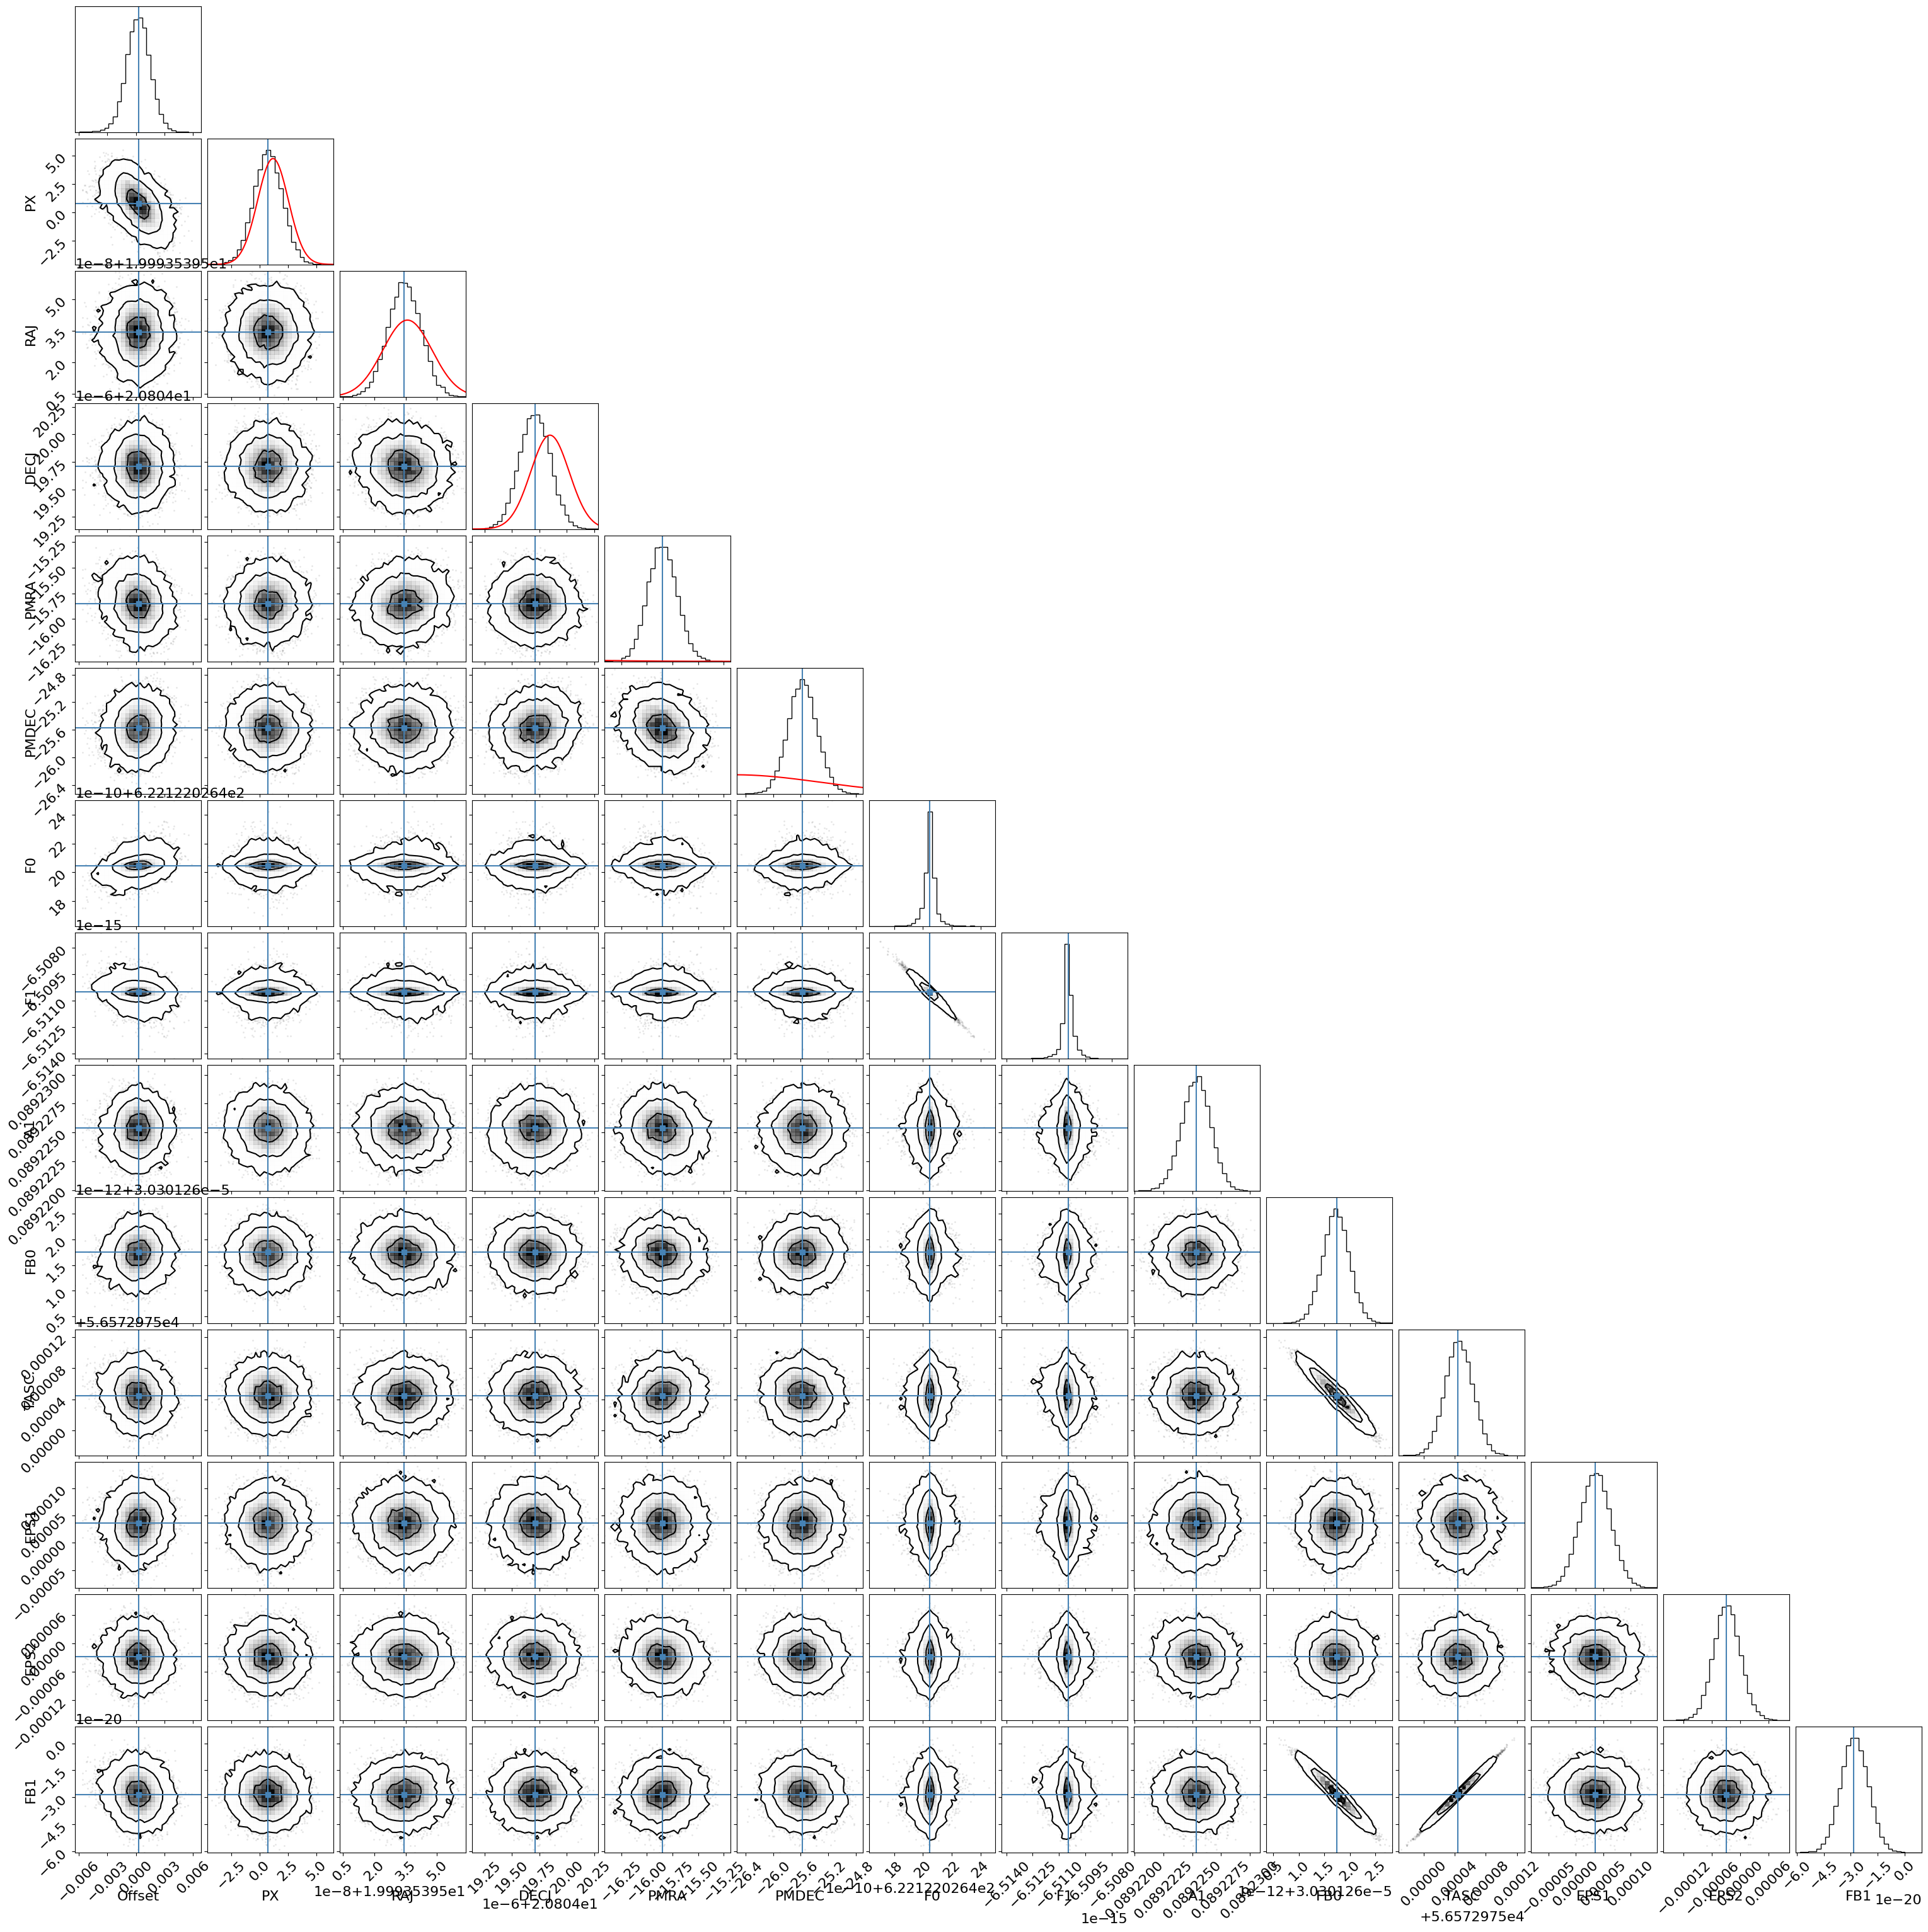

In [7]:
fig = res.timing_corner(nWX=psr.nWXfreqs)
plt.show()

### Compute an upper limit on the GWB amplitude

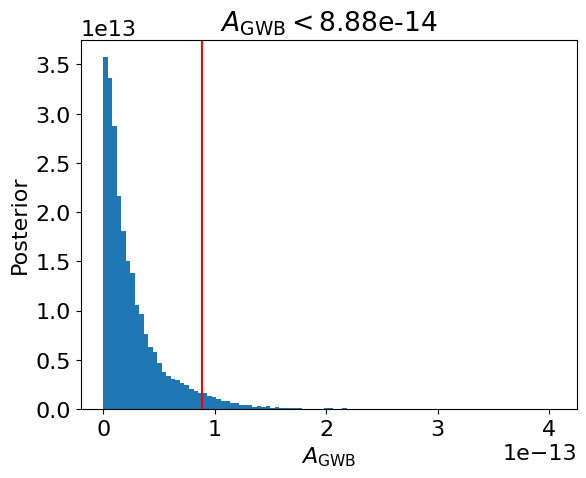

In [8]:
logAgwbs = res.hyp_chain[:,0]

Agwbs = 10 ** logAgwbs
plt.hist(Agwbs,100,density=True)
plt.xlabel('$A_{\\rm GWB}$')
plt.ylabel('Posterior')
A_95 = np.quantile(Agwbs, 0.95)
plt.axvline(A_95,color='red')
plt.title(f'$A_{{\\rm GWB}} < ${A_95:.3g}')
plt.show()


### Reweight the posterior samples to estimate the log-likelihood for the amplitude -- should be flat at low values


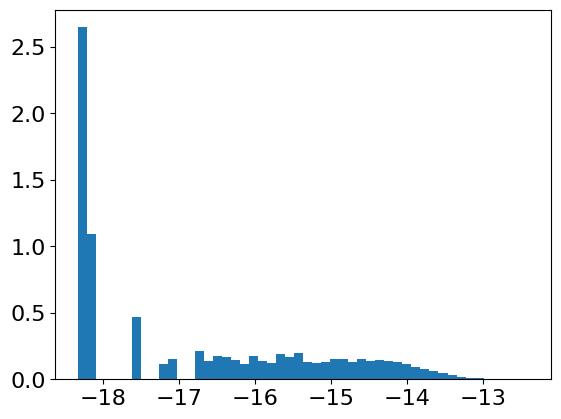

In [10]:
plt.hist(logAgwbs, 50,density=True, weights=np.exp(-logAgwbs * np.log(10)))
plt.show()

### Create Fig. 4 from the paper

990 / 1000

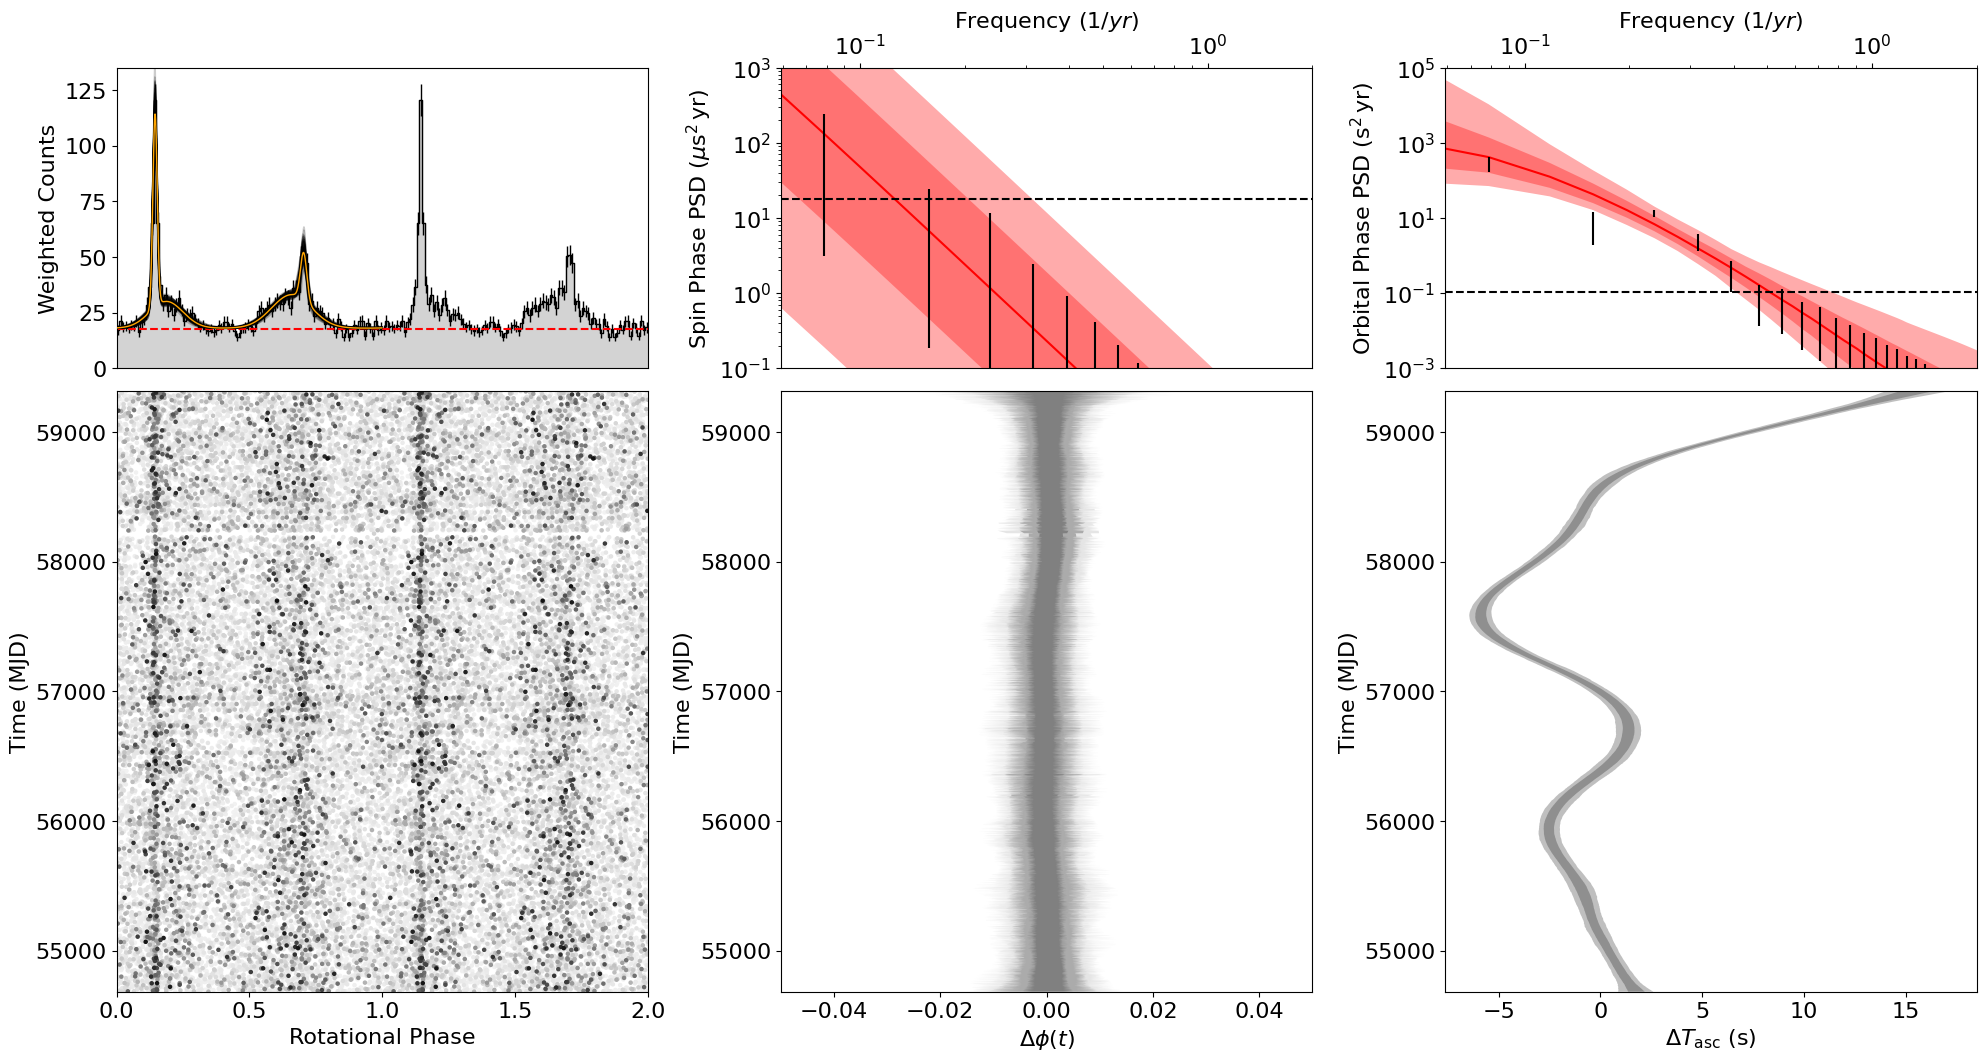

In [12]:
plt.rc('font',size=16)
ax = res.summary_plot(xbins=100, tn_yunits="us ** 2 * yr")
ax[0,1].set_ylim(bottom=1e-1, top=1e3)
ax[0,2].set_ylim(top=1e5,bottom=1e-3)
ax[0,2].set_xlim(left=0.75 / psr.Tobs * 365.25, right=2)
ax[0,1].set_xlim(left=0.75 / psr.Tobs * 365.25, right=2)
ax[1,1].set_xlim(-0.05,0.05)
ax[0,0].set_ylim(top=135)
ax[0,1].set_ylabel('Spin Phase PSD ($\\mu {\\rm s}^2\\, {\\rm yr}$)')
ax[0,2].set_ylabel('Orbital Phase PSD (${\\rm s}^2\\, {\\rm yr}$)')
plt.savefig("B1957_summary.pdf",bbox_inches="tight")
plt.show()
